<a href="https://colab.research.google.com/github/levchenkopavlo/AI/blob/master/12%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BC%D0%B5%D1%80%D0%B5%D0%B6%D1%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [116]:
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [117]:
device

'cuda'

Дані про морське вухо(молюск)

<div>
<img src="https://m.media-amazon.com/images/I/81-FC5TlLtL.jpg" width="500"/>
</div>

In [118]:
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/abalone.csv')
df.drop(columns=['Type', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight'], inplace=True)

In [119]:
print('dimensions: ', df.shape, end='\n\n')
print(df.columns, end='\n\n')
print('types of columns:\n',df.dtypes, end='\n\n', sep='')
print('missing values:\n', df.isnull().sum().to_string(), end='\n\n', sep='')
df.describe()

dimensions:  (4177, 4)

Index(['LongestShell', 'Diameter', 'Height', 'Rings'], dtype='object')

types of columns:
LongestShell    float64
Diameter        float64
Height          float64
Rings             int64
dtype: object

missing values:
LongestShell    0
Diameter        0
Height          0
Rings           0



,LongestShell,Diameter,Height,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,9.933684
std,0.120093,0.099240,0.041827,3.224169
min,0.075000,0.055000,0.000000,1.000000
25%,0.450000,0.350000,0.115000,8.000000
50%,0.545000,0.425000,0.140000,9.000000
75%,0.615000,0.480000,0.165000,11.000000
max,0.815000,0.650000,1.130000,29.000000


In [120]:
df.head()

,LongestShell,Diameter,Height,Rings
0,0.455,0.365,0.095,15
1,0.350,0.265,0.090,7
2,0.530,0.420,0.135,9
3,0.440,0.365,0.125,10
4,0.330,0.255,0.080,7


Потрібно на основі розмірів молюска спрогнозувати кількість кілець в мушлі `Rings`. Використовуйте процесор cpu

# Завдання 1
Створіть клас Dataset

In [121]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values).to(device)
      self.y = torch.FloatTensor(y.values).to(device)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Rings'])
y = df['Rings']

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [122]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset,  # датасет з даними
                        batch_size=batch_size,  # кількість даних в одному пакеті
                        shuffle=True,  # чи треба перемішувати дані
                        generator=torch.Generator(device=device)) # підключення до процесора)

In [123]:
X_batch, y_batch = next(iter(dataloader))

In [124]:
X_batch.shape

torch.Size([128, 3])

In [125]:
y_batch.shape

torch.Size([128, 1])

In [126]:
X_batch.device

device(type='cuda', index=0)

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-3
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [127]:
from torch import nn


model = nn.Sequential(
    nn.Linear(3, 8),
    nn.ReLU(),
    nn.Linear(8, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

model

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=6, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6, out_features=1, bias=True)
)

In [128]:
from torchsummary import summary

summary(model, input_size=(3,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              32
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 6]              54
              ReLU-4                    [-1, 6]               0
            Linear-5                    [-1, 1]               7
Total params: 93
Trainable params: 93
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [129]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.MSELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [130]:
import numpy as np

num_epochs = 15
losses = []

for epoch in range(num_epochs):
  losses_ = []
  for X_batch, y_batch in dataloader:
        # пряме поширення
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward() # рахуємо градієнти
        optimizer.step()
        optimizer.zero_grad()

  losses.append(np.mean(losses_))

  if epoch % 1 == 0:
          print(f'loss={losses[-1]}')

loss=94.20898113828717
loss=64.1491926944617
loss=17.310271494316332
loss=8.682071873635957
loss=8.654791355133057
loss=8.569430394606156
loss=8.531221664313113
loss=8.496930050127434
loss=8.452701929843787
loss=8.379061265425248
loss=8.375006068836559
loss=8.32646131515503
loss=8.285719452482281
loss=8.263646443684896
loss=8.199131416551994


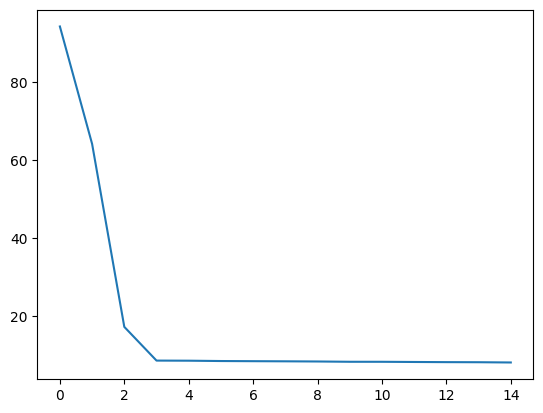

In [131]:
import matplotlib.pyplot as plt

plt.plot(losses)
# plt.ylim(0, 0.25*1e8)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [132]:
torch.save(model, 'model.pt')

load_model = torch.load('model.pt')
load_model

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=6, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6, out_features=1, bias=True)
)

In [133]:
df.iloc[:1]

,LongestShell,Diameter,Height,Rings
0,0.455,0.365,0.095,15


In [134]:
X.iloc[:1]

,LongestShell,Diameter,Height
0,0.455,0.365,0.095


In [135]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.4550, 0.3650, 0.0950]], device='cuda:0')
torch.Size([1, 3])


In [136]:
load_model(X_data) # порахує градієнти

tensor([[9.6096]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [137]:
with torch.no_grad(): # без градієнтів
  print(load_model(X_data))

tensor([[9.6096]], device='cuda:0')
